In [2]:
from IPython.core.display import HTML
HTML("""
<style>
// img[alt$=">"] {
  float: right;
}

img[alt$="<"] {
  float: left;
}

img[alt$="><"] {
  display: block;
  max-width: 100%;
  height: auto;
  margin: auto;
  float: none!important;
}
</style>
""")

![Dask_presentation_array><](Dask_presentation_array.png)

# Dask Arrays

## Manipulate heavy objects

In [1]:
import numpy as np

In [2]:
size=2000
numpy_arr = np.random.random((size,size,size))

MemoryError: Unable to allocate 59.6 GiB for an array with shape (2000, 2000, 2000) and data type float64

In [3]:
import dask.array as da
import dask

In [4]:
chunk = 'auto'
dask_cube = da.random.random((size,size,size), chunks=(chunk,chunk,chunk))
dask_cube

dask.array<random_sample, shape=(2000, 2000, 2000), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

In [5]:
mean_dcube = dask_cube.mean()

In [6]:
mean_dcube

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [9]:
%%time
mean_dcube.compute()

Wall time: 21.4 s


0.5000009984767866

## Visualize the task graph with ***graphviz***

In [7]:
size = 15

In [8]:
dask_arr = da.random.random((size, size), chunks=(5,5))

In [9]:
dask_arr

dask.array<random_sample, shape=(15, 15), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

In [10]:
comp = da.mean(dask_arr.sum(axis=0))

In [11]:
comp

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

### Low level graph

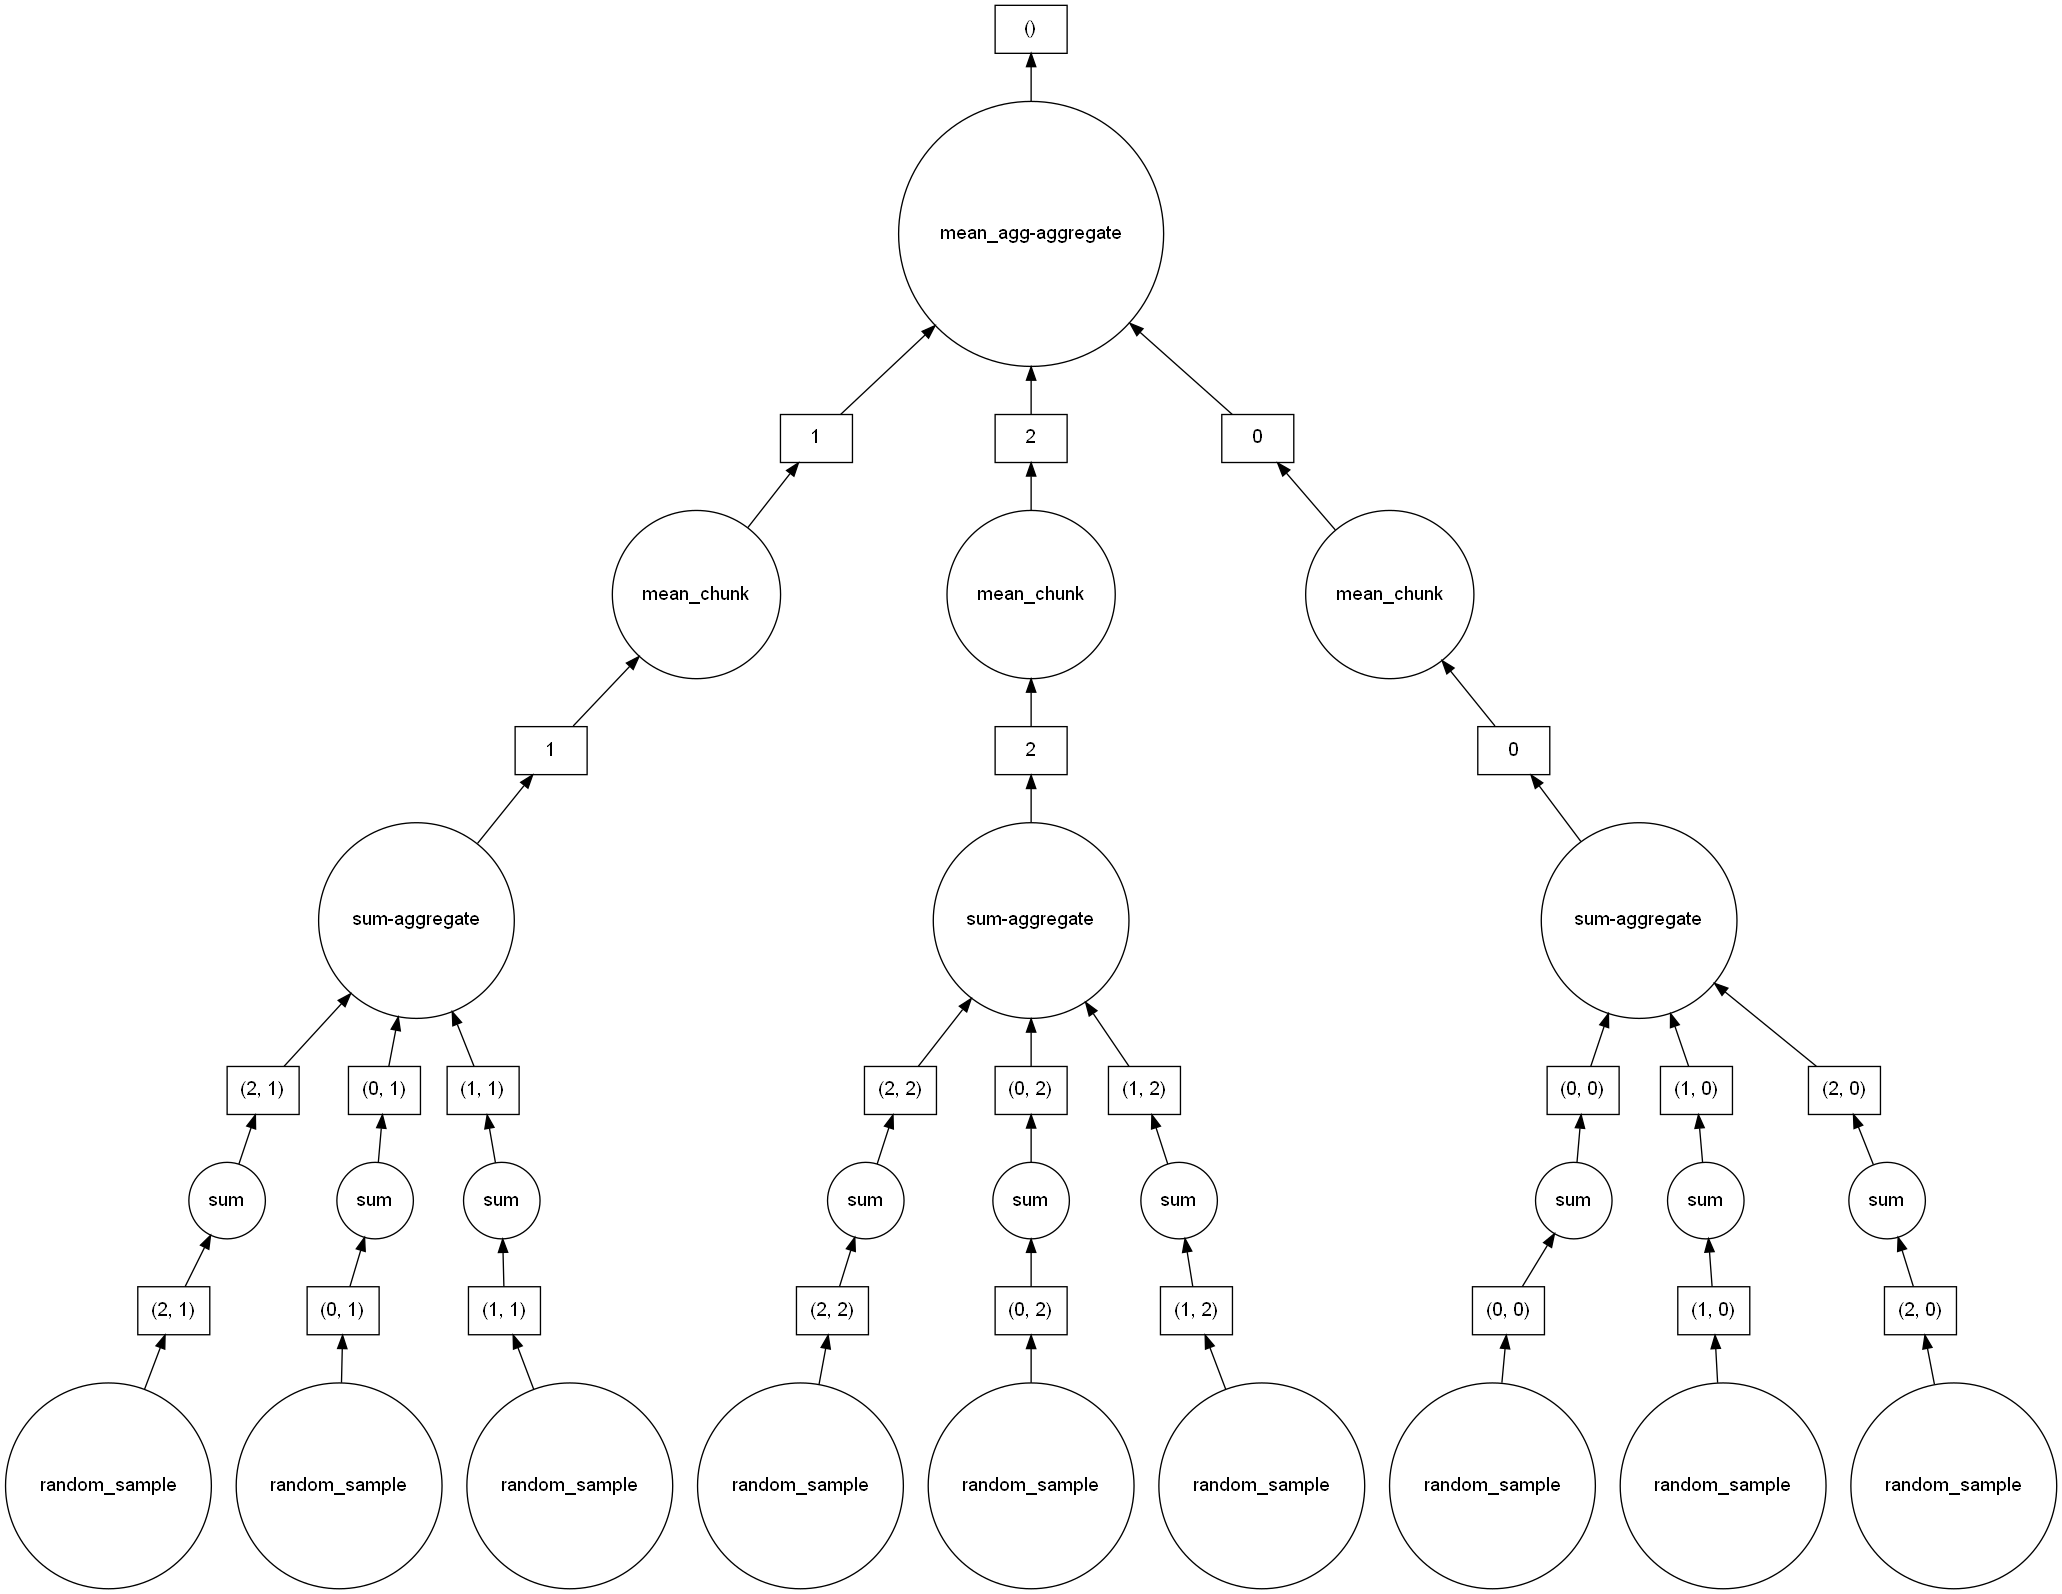

In [12]:
comp.visualize(bgcolor='transparent')

### High level graph (HTML rep)

In [13]:
comp.dask

HighLevelGraph with 5 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x1e854e4d910>
 0. random_sample-ec305d63e58fa0b8980025c5defbf200
 1. sum-d456be63e5e5f2761965ab1c05c39f35
 2. sum-aggregate-9fa233c165d92f739bd4a0f6e8222768
 3. mean_chunk-732bbd6d4d8b570672b4e88bfafe6ca0
 4. mean_agg-aggregate-e9f8920e2559a207fd3e99fd5f9c5f86

### Many layers

In [14]:
dask_arr = da.random.random((size, size), chunks=(5, 5))
comp = (dask_arr.dot(dask_arr.T + 1) - dask_arr.mean()).std()

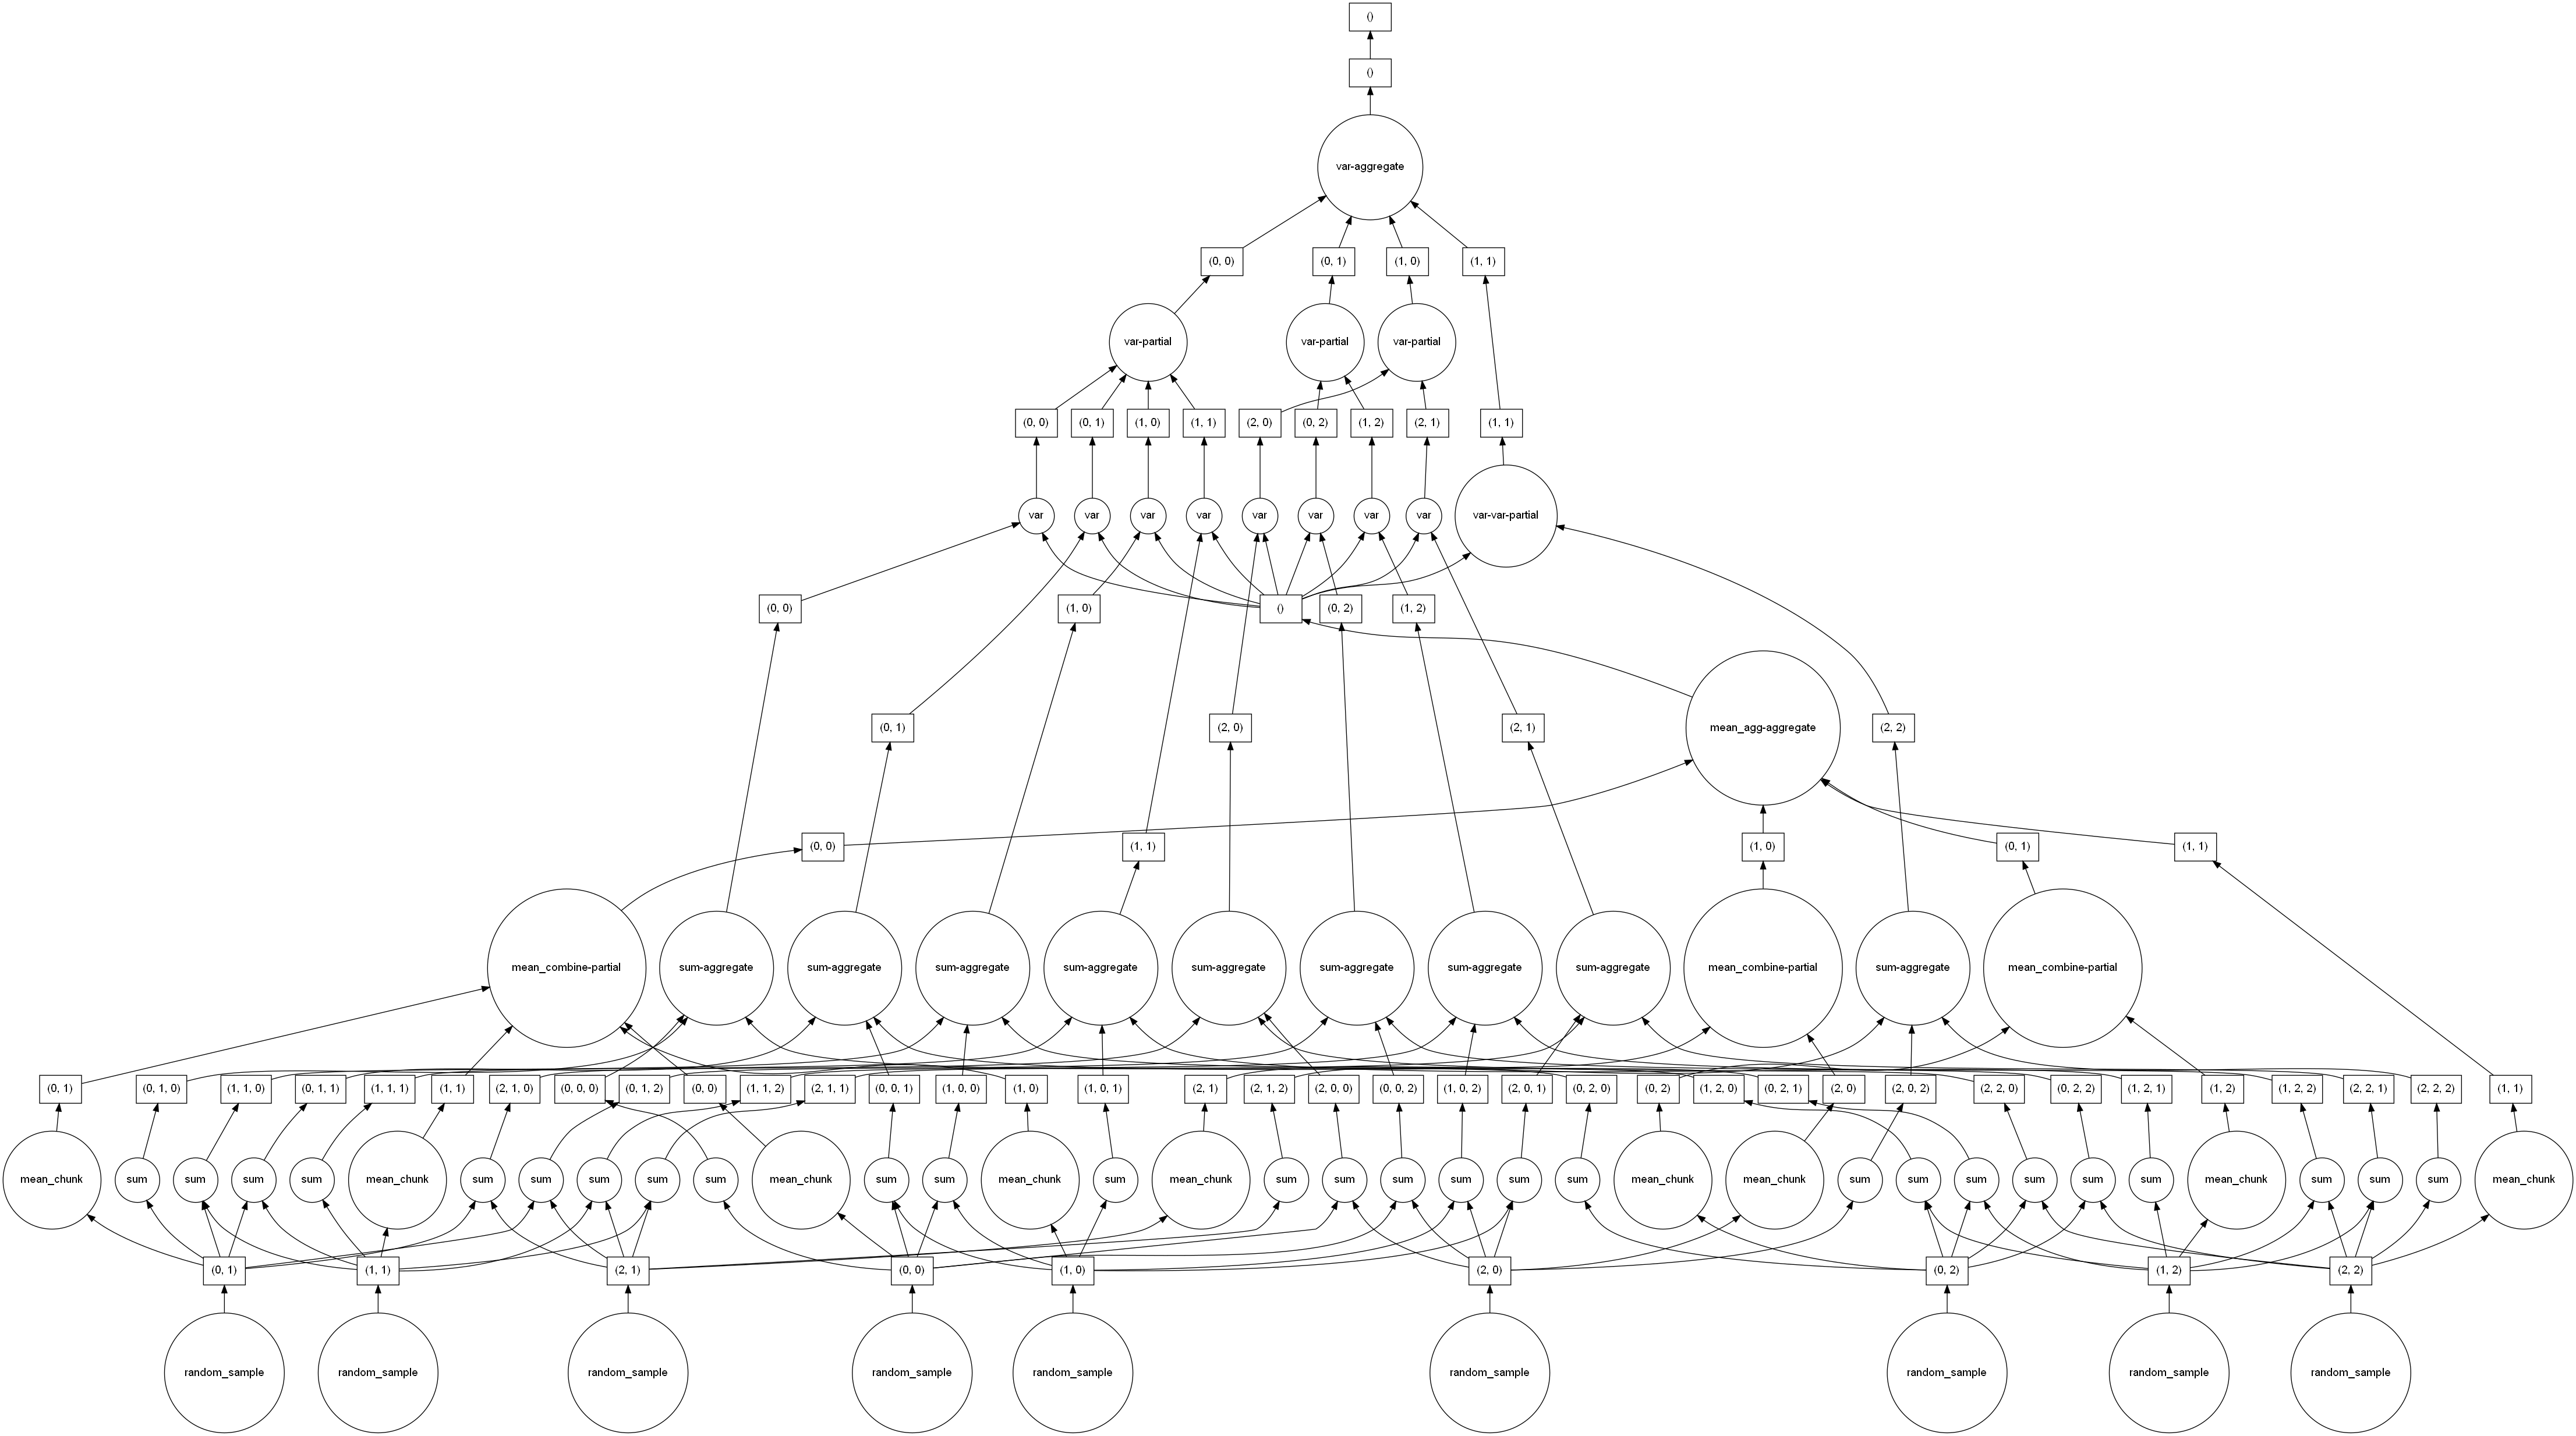

In [15]:
comp.visualize(bgcolor="transparent", optimize_graph=True)

In [16]:
std_comp = comp.compute()
std_comp

1.449992251453347

### Custom computation

In [18]:
size=1000

In [19]:
vx = da.random.normal(size=(size, size, size))
vy = da.random.normal(size=(size, size, size))
vz = da.random.normal(size=(size, size, size))

In [20]:
vx

dask.array<normal, shape=(1000, 1000, 1000), dtype=float64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

$V = \frac{1}{N}\sqrt{(\sum{v_x})^2 + (\sum{v_y})^2 + (\sum{v_z})^2}$

In [21]:
V = da.sqrt(da.mean(vx)**2 + da.mean(vy)**2 + da.mean(vz)**2)

In [22]:
V

dask.array<sqrt, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

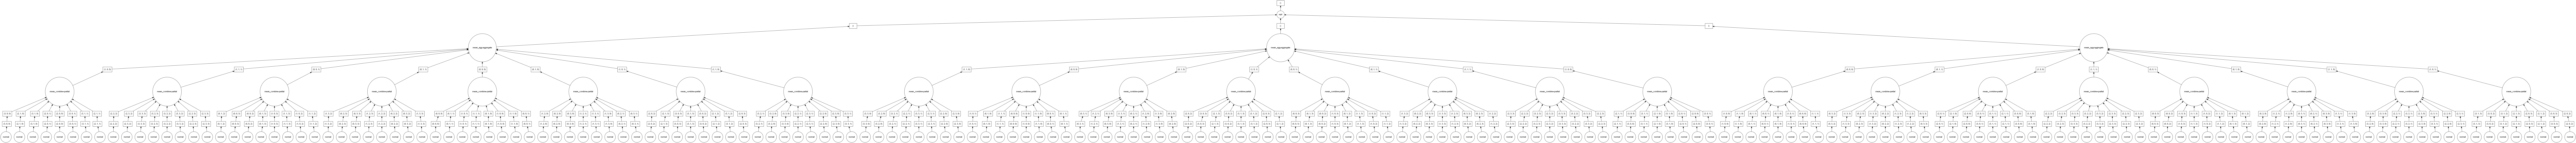

In [31]:
V.visualize( optimize_graph=True)

In [33]:
%%time
V.compute()

Wall time: 15.6 s


5.065004296324993e-05

### Plot histogram from $10^9$ points

Wall time: 21.5 s


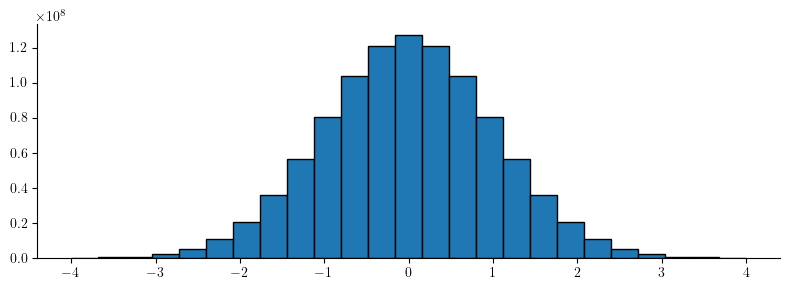

In [34]:
%%time
h, bins = da.histogram(vx, bins=25, range=[-4,4])

import matplotlib.pyplot as plt
plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Latin Modern Roman",
    })

fig,ax=plt.subplots(figsize=(8,3))
cbin=[(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
width = abs((bins[1]-bins[0]))
ax.bar(cbin, h.compute(), width, ec='k',fc=None)
ax.spines[['right','top']].set_visible(False)
fig.tight_layout()